# Prepare dataset

## Individual process

In [9]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfiltfilt, hilbert
from tqdm import tqdm


def fixation_bandpower_hilbert(df_page):
    """
    Compute fixation-aligned EEG bandpower features using:
      1) Band-pass filter per frequency band (SciPy butter + sosfiltfilt)
      2) Hilbert transform to obtain analytic signal
      3) Instantaneous bandpower time series = |analytic|^2 (log10 transformed)
      4) Aggregate bandpower within each fixation window using sample indices

    Expected input `df_page`:
      - Rows are time samples, ordered in time)
      - First 64 columns are EEG channel values (continuous EEG samples)
      - Columns include:
          sfreq (constant per run/page is fine),
          fix_R_tStart, fix_R_tEnd,
          is_mw,
          fix_R_fixed_word, fix_R_fixed_word_key,
          sentence_id, sentence

    Returns:
      DataFrame with one row per fixation interval and columns:
        {ch}_{band} for 64*8 features + metadata cols.
    """

    bands = {
        "theta1": (4.0, 6.0),
        "theta2": (6.5, 8.0),
        "alpha1": (8.5, 10.0),
        "alpha2": (10.5, 13.0),
        "beta1":  (13.5, 18.0),
        "beta2":  (18.5, 30.0),
        "gamma1": (30.5, 40.0),
        "gamma2": (40.0, 49.5),
    }

    # ---------------------------
    # EEG: (n_ch, n_times)
    # ---------------------------
    eeg = df_page.iloc[:, :64].to_numpy(dtype=np.float64).T
    n_ch, n_times = eeg.shape

    ch_names = df_page.columns.values[:64].tolist()
    sfreq = float(df_page["sfreq"].iloc[0])
    nyq = sfreq / 2.0

    # ---------------------------
    # Build fixation index table: one row per fixation interval
    # start_idx/end_idx are *sample indices* (row indices) within df_page
    # ---------------------------
    df_fix_idx = (
        df_page.dropna(subset=[
            "fix_R_tStart", "fix_R_tEnd",
            "is_mw", "fix_R_fixed_word", "fix_R_fixed_word_key",
            "sentence_id", "sentence",
        ])
        .reset_index()  # creates column "index" = original sample row index
        .groupby(["fix_R_tStart", "fix_R_tEnd"], as_index=False)
        .agg(
            start_idx=("index", "min"),
            end_idx=("index", "max"),
            is_mw=("is_mw", "mean"),
            fix_R_fixed_word=("fix_R_fixed_word", "first"),
            fix_R_fixed_word_key=("fix_R_fixed_word_key", "first"),
            sentence_id=("sentence_id", "first"),
            sentence=("sentence", "first"),
        )
        .sort_values(["fix_R_tStart", "fix_R_tEnd"])
        .reset_index(drop=True)
    )

    if df_fix_idx.empty:
        # no fixations found on this page
        return pd.DataFrame()

    start_samp = np.clip(df_fix_idx["start_idx"].to_numpy(), 0, n_times - 1)
    end_samp   = np.clip(df_fix_idx["end_idx"].to_numpy(),   0, n_times - 1)

    band_names = list(bands.keys())
    band_ranges = [bands[b] for b in band_names]
    n_fix = len(df_fix_idx)
    n_bands = len(band_names)

    feat = np.full((n_fix, n_ch, n_bands), np.nan, dtype=np.float64)

    # ---------------------------
    # Filter + Hilbert per band, then aggregate per fixation
    # ---------------------------
    for bi, (fmin, fmax) in enumerate(band_ranges):
        # SciPy band-pass (zero-phase)
        sos = butter(
            N=4,
            Wn=[fmin / nyq, fmax / nyq],
            btype="bandpass",
            output="sos",
        )
        x_filt = sosfiltfilt(sos, eeg, axis=1)           # filter over time
        x_analytic = hilbert(x_filt, axis=1)             # hilbert over time
        power = np.abs(x_analytic) ** 2                  # (n_ch, n_times)
        # power = np.log10(power + 1e-20)                  # log power

        for i in range(n_fix):
            s = int(start_samp[i])
            e = int(end_samp[i])
            if e < s:
                continue
            feat[i, :, bi] = np.nanmean(power[:, s:e+1], axis=1)

    # Flatten features: (n_fix, n_ch*n_bands)
    feat_flat = feat.reshape(n_fix, n_ch * n_bands)
    columns = [f"{ch}_{band}" for ch in ch_names for band in band_names]
    df_psd = pd.DataFrame(feat_flat, columns=columns)

    # Attach fixation metadata
    df_psd = pd.concat([df_psd, df_fix_idx[[
        "is_mw",
        "fix_R_fixed_word",
        "fix_R_fixed_word_key",
        "sentence_id",
        "sentence",
    ]].reset_index(drop=True)], axis=1)

    return df_psd


# ==========================
# Main processing
# ==========================
data_root = "/gpfs1/pi/djangraw/mindless_reading/data"
coords_root = "/gpfs1/pi/djangraw/hsun11/roamm_ml/res"

all_subjects = sorted(
    d for d in os.listdir(data_root)
    if d.startswith("s") and os.path.isdir(os.path.join(data_root, d))
)

for subject_id in all_subjects:
    print(f"Processing subject {subject_id}...")
    ml_data_dir = os.path.join(data_root, subject_id, "ml_data")
    save_dir = os.path.join(ml_data_dir, "eeg2text_data")
    os.makedirs(save_dir, exist_ok=True)

    pkl_files = sorted([f for f in os.listdir(ml_data_dir) if f.endswith(".pkl")])

    # make sure each subject has 5 runs of data
    if len(pkl_files) != 5:
        raise ValueError(f"Subject {subject_id} has {len(pkl_files)} runs instead of 5")

    subject_rows = []  # collect per-page fixation-level dfs, concat once

    for pkl_file in tqdm(pkl_files, desc=f"{subject_id} runs", unit="run", leave=False):
        df = pd.read_pickle(os.path.join(ml_data_dir, pkl_file))

        # Filter: first pass reading only
        if "first_pass_reading" in df.columns:
            df = df[df["first_pass_reading"] == 1].copy()

        # convert bool col explicitly to avoid pandas warning
        for col in ['is_blink', 'is_sacc', 'is_fix', 'is_mw', 'first_pass_reading']:
            df[col] = df[col] == True

        # Filter out samples 2 seconds before page end
        if "time" in df.columns and "page_end" in df.columns:
            df = df[df["time"] < (df["page_end"] - 2)].copy()

        df["subject_id"] = subject_id

        # Sentence info merge (word_key)
        story_name = df["story_name"].iloc[0]
        coord_path = os.path.join(coords_root, f"{story_name}_coordinates.csv")
        df_coords = pd.read_csv(coord_path)

        df = df.merge(
            df_coords[["sentence_id", "sentence", "word_key"]],
            left_on="fix_R_fixed_word_key",
            right_on="word_key",
            how="left",
        )

        # Process each page
        pages = sorted(df["page_num"].unique().tolist())
        for page in pages:
            df_page = df[df["page_num"] == page].copy()
            df_fix_eeg = fixation_bandpower_hilbert(df_page)
            if df_fix_eeg.empty:
                continue
            # Add metadata columns
            df_fix_eeg["page_num"] = page
            df_fix_eeg["story_name"] = story_name
            df_fix_eeg["subject_id"] = subject_id
            subject_rows.append(df_fix_eeg)

    if len(subject_rows) == 0:
        Warning(f"No fixation data found for subject {subject_id}, saving empty file.")

    df_group = pd.concat(subject_rows, ignore_index=True)
    out_path = os.path.join(save_dir, f"{subject_id}_eeg2text_data.csv")
    df_group.to_csv(out_path, index=False)


Processing subject s10014...


s10014 runs:   0%|          | 0/5 [00:00<?, ?run/s]

Processing subject s10052...


Processing subject s10059...


Processing subject s10073...


Processing subject s10081...


Processing subject s10084...


Processing subject s10085...


Processing subject s10089...


Processing subject s10094...


Processing subject s10100...


Processing subject s10103...


Processing subject s10110...


Processing subject s10111...


Processing subject s10115...


Processing subject s10117...


Processing subject s10121...


Processing subject s10125...


Processing subject s10138...


Processing subject s10139...


Processing subject s10141...


Processing subject s10144...


Processing subject s10145...


Processing subject s10148...


Processing subject s10153...


Processing subject s10156...


Processing subject s10158...


Processing subject s10159...


Processing subject s10160...


Processing subject s10165...


Processing subject s10173...


Processing subject s10177...


Processing subject s10178...


Processing subject s10180...


Processing subject s10181...


Processing subject s10183...


Processing subject s10185...


Processing subject s10186...


Processing subject s10188...


Processing subject s10192...


Processing subject s10195...


Processing subject s10196...


Processing subject s10197...


Processing subject s10200...


Processing subject s10202...


## Merge subject files

In [10]:
import os
import pandas as pd

data_root = "/gpfs1/pi/djangraw/mindless_reading/data"
all_subjects = sorted(
    d for d in os.listdir(data_root)
    if d.startswith("s") and os.path.isdir(os.path.join(data_root, d))
)
df_list = []

for subject_id in all_subjects:
    ml_data_dir = os.path.join(data_root, subject_id, "ml_data")
    save_dir = os.path.join(ml_data_dir, "eeg2text_data")
    infile = os.path.join(save_dir, f"{subject_id}_eeg2text_data.csv")

    df = pd.read_csv(infile)

    df["subject_id"] = subject_id  # enforce subject_id is correct
    df_list.append(df)

if len(df_list) == 0:
    raise RuntimeError("No subject EEG2Text files were loaded. Nothing to concatenate.")

df_all = pd.concat(df_list, ignore_index=True)
out_file = os.path.join(data_root, "all_subjects_eeg2text_data.csv")
df_all.to_csv(out_file, index=False)

print(f"\nSaved merged dataset to:\n  {out_file}")
print(f"Total rows: {len(df_all):,}")
print(f"Total subjects loaded: {df_all['subject_id'].nunique()}")


Saved merged dataset to:
  /gpfs1/pi/djangraw/mindless_reading/data/all_subjects_eeg2text_data.csv
Total rows: 394,319
Total subjects loaded: 44


## Average subject fixations

In [ ]:
import os
import numpy as np
import pandas as pd

data_root = "/gpfs1/pi/djangraw/mindless_reading/data"
df = pd.read_csv(os.path.join(data_root, "all_subjects_eeg2text_data.csv"))

# 0/NaN -> False, >0 -> True
df["is_mw"] = pd.to_numeric(df["is_mw"], errors="coerce").fillna(0).gt(0)

sentence_id_col = "sentence_id"
sentence_col = "sentence"
fix_key_col = "fix_R_fixed_word_key"

meta_cols = {
    sentence_id_col, sentence_col, fix_key_col,
    "fix_R_fixed_word", "is_mw", "page_num", "story_name", "subject_id",
}

# EEG columns = numeric columns not in meta
eeg_cols = [c for c in df.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(df[c])]
if len(eeg_cols) == 0:
    raise ValueError("No numeric EEG feature columns found (after excluding meta columns).")

# Group by (sentence + word_key + MW) and average EEG features
df_avg = (
    df.dropna(subset=[sentence_id_col, sentence_col, fix_key_col, "fix_R_fixed_word", "is_mw"])
      .groupby([sentence_id_col, sentence_col, fix_key_col, "fix_R_fixed_word", "is_mw"], as_index=False)[eeg_cols]
      .mean()
)

# df_avg.to_csv(os.path.join(data_root, "all_subjects_eeg2text_data_avg.csv"), index=False)
# print("Saved averaged EEG2Text dataset.")

## Average subject fixations (based on sample points)

In [1]:
import os
import numpy as np
import pandas as pd

data_root = "/gpfs1/pi/djangraw/mindless_reading/data"
df = pd.read_csv(os.path.join(data_root, "all_subjects_eeg2text_data.csv"))

# 0/NaN -> False, >0 -> True
df["is_mw"] = pd.to_numeric(df["is_mw"], errors="coerce").fillna(0).gt(0)

key = "fix_R_fixed_word_key"
seed = 42
# drop rows without key (otherwise groupby gets messy)
df = df.dropna(subset=[key]).reset_index(drop=True)

df_mw = df[df["is_mw"]].copy()
df_nm = df[~df["is_mw"]].copy()
# MW counts per word_key
mw_counts = df_mw[key].value_counts()

# Only keep non-MW word_keys that exist in MW (so distribution matches)
df_nm = df_nm[df_nm[key].isin(mw_counts.index)].copy()

# For each word_key, sample non-MW up to MW count for that key
def sample_nm_group(g: pd.DataFrame) -> pd.DataFrame:
    k = g.name
    n_target = int(mw_counts.get(k, 0))
    if n_target <= 0:
        return g.iloc[0:0]  # empty
    if len(g) <= n_target:
        return g
    return g.sample(n=n_target, random_state=seed)

df_nm_bal = (
    df_nm.groupby(key, group_keys=False)
         .apply(sample_nm_group)
         .reset_index(drop=True)
)

df = pd.concat([df_mw, df_nm_bal], ignore_index=True)

sentence_id_col = "sentence_id"
sentence_col = "sentence"
fix_key_col = "fix_R_fixed_word_key"

meta_cols = {
    sentence_id_col, sentence_col, fix_key_col,
    "fix_R_fixed_word", "is_mw", "page_num", "story_name", "subject_id",
}

# EEG columns = numeric columns not in meta
eeg_cols = [c for c in df.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(df[c])]
if len(eeg_cols) == 0:
    raise ValueError("No numeric EEG feature columns found (after excluding meta columns).")

# Group by (sentence + word_key + MW) and average EEG features
df_avg = (
    df.dropna(subset=[sentence_id_col, sentence_col, fix_key_col, "fix_R_fixed_word", "is_mw"])
      .groupby([sentence_id_col, sentence_col, fix_key_col, "fix_R_fixed_word", "is_mw"], as_index=False)[eeg_cols]
      .mean()
)

df_avg.to_csv(os.path.join(data_root, "all_subjects_eeg2text_data_weightedavg.csv"), index=False)
print("Saved averaged EEG2Text dataset.")

/tmp/ipykernel_3274842/2389204827.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_nm_group)


Saved averaged EEG2Text dataset.


# Examine dataset

In [ ]:
import numpy as np
import pandas as pd

seed = 42
csv_path = "/gpfs1/pi/djangraw/mindless_reading/data/all_subjects_eeg2text_data.csv"

sentence_col = "sentence"

df_all = pd.read_csv(csv_path)

# =========================
# ALL
# =========================
df = df_all.dropna(subset=[sentence_col]).reset_index(drop=True)

subject_id = df['subject_id'].unique().tolist()

sent_texts = df[sentence_col].unique().tolist()
rng = np.random.RandomState(seed)
rng.shuffle(sent_texts)

n = len(sent_texts)
n_train = int(round(0.8 * n))
n_dev = int(round(0.1 * n))

train_ids = set(sent_texts[:n_train])
dev_ids   = set(sent_texts[n_train:n_train + n_dev])
test_ids  = set(sent_texts[n_train + n_dev:])

train_rows = df[sentence_col].isin(train_ids).sum()
dev_rows   = df[sentence_col].isin(dev_ids).sum()
test_rows  = df[sentence_col].isin(test_ids).sum()

print("\n=== ALL ===")
print(f"Sentences total: {n} | train/dev/test: {n_train}/{n_dev}/{n - n_train - n_dev}")
print(f"Rows total: {len(df)} | train/dev/test: {train_rows}/{dev_rows}/{test_rows}")

if "is_mw" in df.columns:
    print(f"MW rate overall: {df['is_mw'].mean():.3f}")
    print(
        "MW rate train/dev/test: "
        f"{df.loc[df[sentence_col].isin(train_ids), 'is_mw'].mean():.3f}/"
        f"{df.loc[df[sentence_col].isin(dev_ids), 'is_mw'].mean():.3f}/"
        f"{df.loc[df[sentence_col].isin(test_ids), 'is_mw'].mean():.3f}"
    )

# =========================
# NR (is_mw == 0)
# =========================
df = df_all[df_all["is_mw"] == 0].dropna(subset=[sentence_col]).reset_index(drop=True)

sent_texts = df[sentence_col].unique().tolist()
rng = np.random.RandomState(seed)
rng.shuffle(sent_texts)

n = len(sent_texts)
n_train = int(round(0.8 * n))
n_dev = int(round(0.1 * n))

train_ids = set(sent_texts[:n_train])
dev_ids   = set(sent_texts[n_train:n_train + n_dev])
test_ids  = set(sent_texts[n_train + n_dev:])

train_rows = df[sentence_col].isin(train_ids).sum()
dev_rows   = df[sentence_col].isin(dev_ids).sum()
test_rows  = df[sentence_col].isin(test_ids).sum()

print("\n=== NR (is_mw == 0) ===")
print(f"Sentences total: {n} | train/dev/test: {n_train}/{n_dev}/{n - n_train - n_dev}")
print(f"Rows total: {len(df)} | train/dev/test: {train_rows}/{dev_rows}/{test_rows}")

# =========================
# MW (is_mw != 0)
# =========================
df = df_all[df_all["is_mw"] != 0].dropna(subset=[sentence_col]).reset_index(drop=True)

sent_texts = df[sentence_col].unique().tolist()
rng = np.random.RandomState(seed)
rng.shuffle(sent_texts)

n = len(sent_texts)
n_train = int(round(0.8 * n))
n_dev = int(round(0.1 * n))

train_ids = set(sent_texts[:n_train])
dev_ids   = set(sent_texts[n_train:n_train + n_dev])
test_ids  = set(sent_texts[n_train + n_dev:])

train_rows = df[sentence_col].isin(train_ids).sum()
dev_rows   = df[sentence_col].isin(dev_ids).sum()
test_rows  = df[sentence_col].isin(test_ids).sum()

print("\n=== MW (is_mw != 0) ===")
print(f"Sentences total: {n} | train/dev/test: {n_train}/{n_dev}/{n - n_train - n_dev}")
print(f"Rows total: {len(df)} | train/dev/test: {train_rows}/{dev_rows}/{test_rows}")
print(
    "MW rate train/dev/test (should be 1.000/1.000/1.000): "
    f"{df.loc[df[sentence_col].isin(train_ids), 'is_mw'].mean():.3f}/"
    f"{df.loc[df[sentence_col].isin(dev_ids), 'is_mw'].mean():.3f}/"
    f"{df.loc[df[sentence_col].isin(test_ids), 'is_mw'].mean():.3f}"
)



=== ALL ===
Sentences total: 487 | train/dev/test: 390/49/48
Rows total: 394319 | train/dev/test: 311552/42577/40190
MW rate overall: 0.071
MW rate train/dev/test: 0.071/0.067/0.075

=== NR (is_mw == 0) ===
Sentences total: 487 | train/dev/test: 390/49/48
Rows total: 366297 | train/dev/test: 291888/40441/33968

=== MW (is_mw != 0) ===
Sentences total: 468 | train/dev/test: 374/47/47
Rows total: 28022 | train/dev/test: 22628/2588/2806
MW rate train/dev/test (should be 1.000/1.000/1.000): 0.998/0.997/1.000


In [6]:
import os
import numpy as np
import pandas as pd

seed = 42
csv_path = "/gpfs1/pi/djangraw/mindless_reading/data/all_subjects_eeg2text_data.csv"
out_csv = "/gpfs1/pi/djangraw/mindless_reading/data/eeg2text_split_stats_by_subject.csv"

sentence_col = "sentence"

df_all = pd.read_csv(csv_path)

# (optional but recommended) drop rows with missing sentence once, up front
df_all = df_all.dropna(subset=[sentence_col]).reset_index(drop=True)

rows_out = []

all_subjects = sorted(df_all["subject_id"].dropna().unique().tolist())

for subject_id in all_subjects:
    df_sub_all = df_all[df_all["subject_id"] == subject_id].copy().reset_index(drop=True)

    for label, df_sub in [
        ("all", df_sub_all),
        ("nr", df_sub_all[df_sub_all["is_mw"] == 0].copy()),
        ("mw", df_sub_all[df_sub_all["is_mw"] != 0].copy()),
    ]:
        df_sub = df_sub.dropna(subset=[sentence_col]).reset_index(drop=True)

        # if a subject has no rows for this subset, record zeros
        if len(df_sub) == 0:
            rows_out.append({
                "subject_id": subject_id,
                "subset": label,
                "n_sentences_total": 0,
                "n_sentences_train": 0,
                "n_sentences_dev": 0,
                "n_sentences_test": 0,
                "n_rows_total": 0,
                "n_rows_train": 0,
                "n_rows_dev": 0,
                "n_rows_test": 0,
                "mw_rate_overall": np.nan,
                "mw_rate_train": np.nan,
                "mw_rate_dev": np.nan,
                "mw_rate_test": np.nan,
            })
            continue

        # split by unique sentence text
        sent_texts = df_sub[sentence_col].unique().tolist()
        rng = np.random.RandomState(seed)
        rng.shuffle(sent_texts)

        n = len(sent_texts)
        n_train = int(round(0.8 * n))
        n_dev = int(round(0.1 * n))

        train_ids = set(sent_texts[:n_train])
        dev_ids   = set(sent_texts[n_train:n_train + n_dev])
        test_ids  = set(sent_texts[n_train + n_dev:])

        train_mask = df_sub[sentence_col].isin(train_ids)
        dev_mask   = df_sub[sentence_col].isin(dev_ids)
        test_mask  = df_sub[sentence_col].isin(test_ids)

        # MW rates (only meaningful for subset=all; nr/mw will be 0/1)
        if "is_mw" in df_sub.columns:
            mw_rate_overall = float(df_sub["is_mw"].mean())
            mw_rate_train = float(df_sub.loc[train_mask, "is_mw"].mean()) if train_mask.any() else np.nan
            mw_rate_dev   = float(df_sub.loc[dev_mask, "is_mw"].mean()) if dev_mask.any() else np.nan
            mw_rate_test  = float(df_sub.loc[test_mask, "is_mw"].mean()) if test_mask.any() else np.nan
        else:
            mw_rate_overall = mw_rate_train = mw_rate_dev = mw_rate_test = np.nan

        rows_out.append({
            "subject_id": subject_id,
            "subset": label,
            "n_sentences_total": n,
            "n_sentences_train": n_train,
            "n_sentences_dev": n_dev,
            "n_sentences_test": n - n_train - n_dev,
            "n_rows_total": len(df_sub),
            "n_rows_train": int(train_mask.sum()),
            "n_rows_dev": int(dev_mask.sum()),
            "n_rows_test": int(test_mask.sum()),
            "mw_rate_overall": mw_rate_overall,
            "mw_rate_train": mw_rate_train,
            "mw_rate_dev": mw_rate_dev,
            "mw_rate_test": mw_rate_test,
        })

df_stats = pd.DataFrame(rows_out)
df_stats.to_csv(out_csv, index=False)

print(f"Saved stats to: {out_csv}")
print(df_stats.head(10))


Saved stats to: /gpfs1/pi/djangraw/mindless_reading/data/eeg2text_split_stats_by_subject.csv
  subject_id subset  n_sentences_total  n_sentences_train  n_sentences_dev  \
0     s10014    all                336                269               34   
1     s10014     nr                285                228               28   
2     s10014     mw                110                 88               11   
3     s10052    all                449                359               45   
4     s10052     nr                398                318               40   
5     s10052     mw                 82                 66                8   
6     s10059    all                451                361               45   
7     s10059     nr                442                354               44   
8     s10059     mw                 15                 12                2   
9     s10073    all                436                349               44   

   n_sentences_test  n_rows_total  n_rows_train 

# Plot EEG and eye-tracking

Loading data from: /gpfs1/pi/djangraw/mindless_reading/data/s10110/ml_data/s10110_run1_ml_data.pkl
Loaded 249856 samples with 139 columns
Time range: 0.00 - 976.00 seconds
Plotting 12 representative EEG channels from 100 to 103 seconds
Channel selection mode: reading
Selected channels: F3, F4, T7, T8, P3, P4, O1, O2, Fz, Pz, C3, C4


/tmp/ipykernel_3428092/3574648329.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mw_data = df_plot['is_mw'].fillna(0)


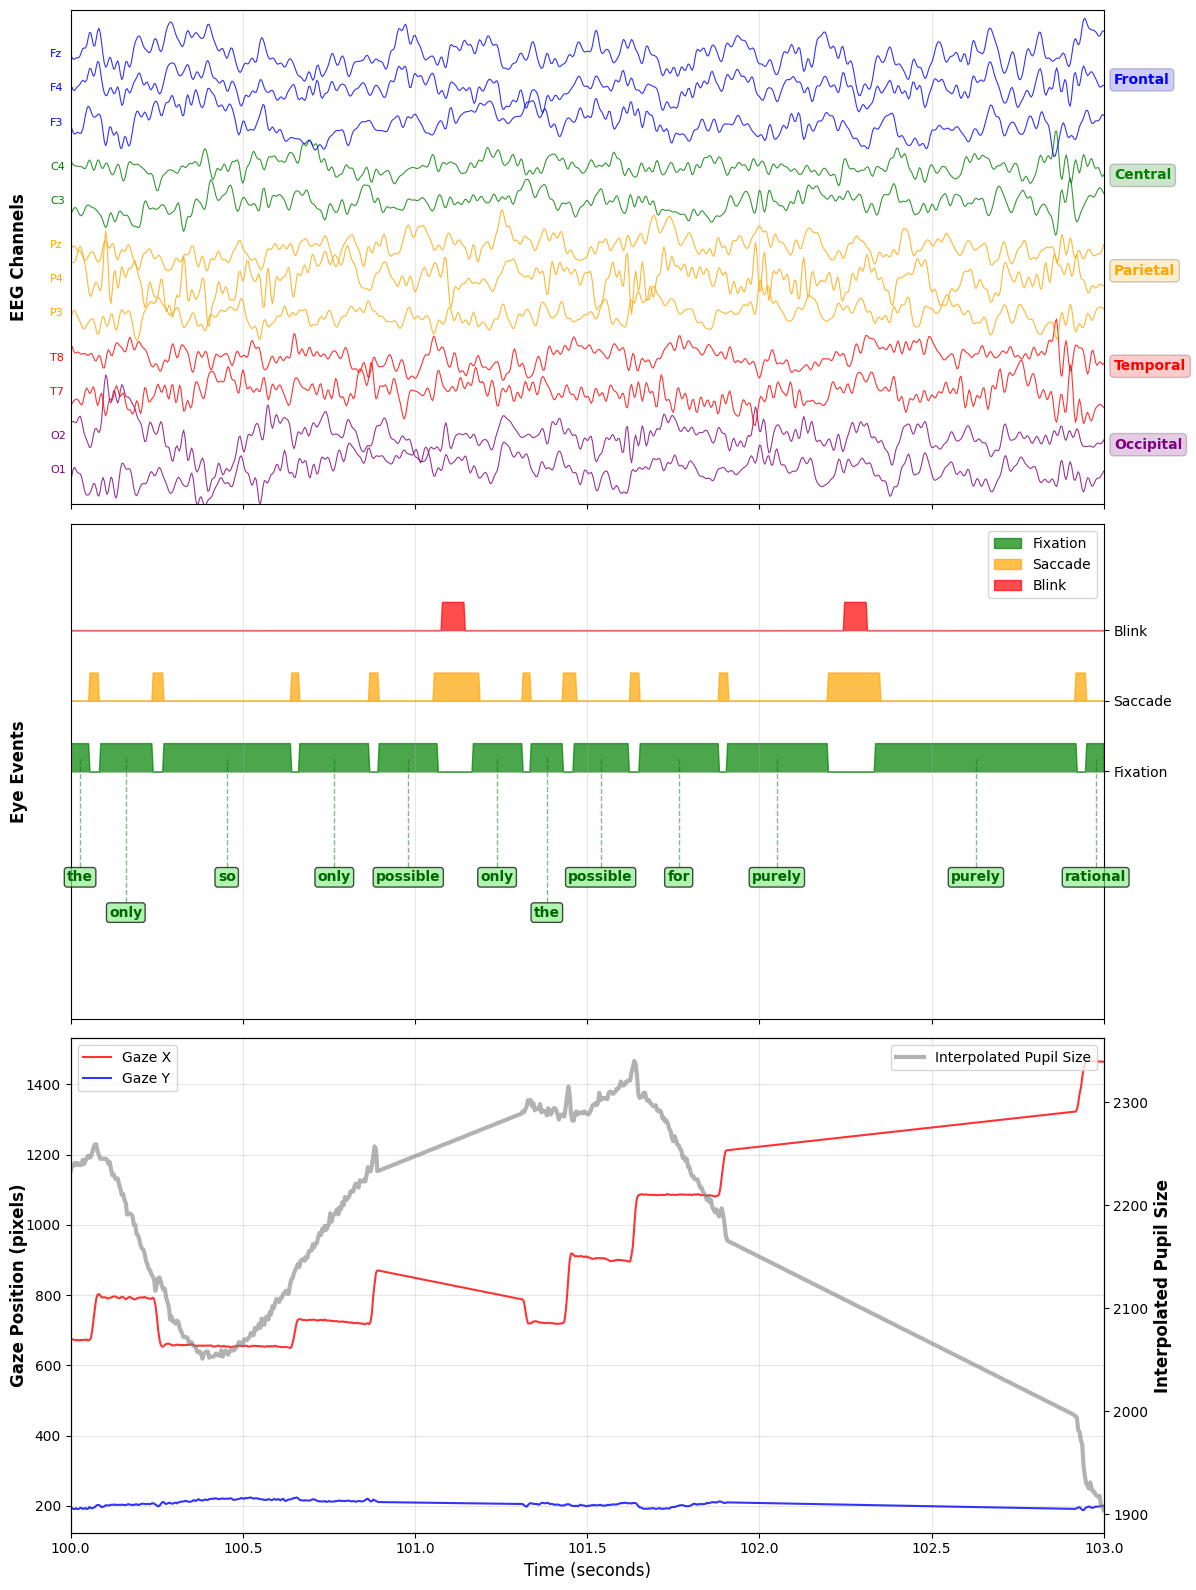


=== Data Summary ===
Blink time: 0.13s (4.4%)
Mind-wandering time: 0.00s (0.0%)


/tmp/ipykernel_3428092/3574648329.py:411: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mw_time = df_plot['is_mw'].fillna(0).sum() / df_plot['sfreq'].iloc[0]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def load_ml_data(subject_id, run_number, data_root=r"/gpfs1/pi/djangraw/mindless_reading/data"):
    """
    Load ML-ready dataset with synchronized EEG and eye-tracking data
    
    Parameters:
    subject_id (str): Subject ID (e.g., 's10014')
    run_number (int): Run number (1-5)
    data_root (str): Root directory containing subject data
    
    Returns:
    pandas.DataFrame: Combined EEG and eye-tracking data
    """
    file_path = os.path.join(data_root, subject_id, 'ml_data', f'{subject_id}_run{run_number}_ml_data.pkl')
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        print("Available files:")
        ml_dir = os.path.join(data_root, subject_id, 'ml_data')
        if os.path.exists(ml_dir):
            files = os.listdir(ml_dir)
            for f in files:
                print(f"  {f}")
        return None
    
    print(f"Loading data from: {file_path}")
    df = pd.read_pickle(file_path)
    print(f"Loaded {len(df)} samples with {len(df.columns)} columns")
    print(f"Time range: {df['time'].min():.2f} - {df['time'].max():.2f} seconds")
    
    return df

def get_representative_channels(all_channels, mode='comprehensive'):
    """
    Select representative EEG channels from different brain regions
    
    Parameters:
    all_channels (list): List of all available EEG channel names
    mode (str): Selection mode - 'comprehensive', 'reading', 'attention', or 'minimal'
    
    Returns:
    list: Selected representative channels with region labels
    """
    
    # Define representative channels by brain region (standard 10-20 system)
    channel_regions = {
        # Frontal regions (executive control, attention)
        'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'FC1', 'FC2'],
        
        # Central regions (sensorimotor)
        'Central': ['C3', 'C4', 'Cz', 'CP1', 'CP2'],
        
        # Parietal regions (attention, spatial processing)
        'Parietal': ['P3', 'P4', 'Pz', 'P7', 'P8'],
        
        # Temporal regions (language, memory)
        'Temporal': ['T7', 'T8', 'TP9', 'TP10'],
        
        # Occipital regions (visual processing)
        'Occipital': ['O1', 'O2', 'Oz'],
        
        # Additional channels for comprehensive coverage
        'Additional': ['AF3', 'AF4', 'FC5', 'FC6', 'CP5', 'CP6', 'PO3', 'PO4']
    }
    
    # Different selection modes
    if mode == 'minimal':
        priority_channels = ['Fz', 'Cz', 'Pz', 'Oz', 'F3', 'F4', 'P3', 'P4']
    elif mode == 'reading':
        # Focus on language and reading-related areas
        priority_channels = ['F3', 'F4', 'T7', 'T8', 'P3', 'P4', 'O1', 'O2', 
                           'Fz', 'Pz', 'C3', 'C4', 'TP9', 'TP10']
    elif mode == 'attention':
        # Focus on attention and executive control
        priority_channels = ['F3', 'F4', 'Fz', 'P3', 'P4', 'Pz', 'C3', 'C4', 
                           'FC1', 'FC2', 'CP1', 'CP2']
    else:  # comprehensive
        priority_channels = ['Fz', 'Cz', 'Pz', 'Oz',  # Midline
                           'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',  # Bilateral
                           'T7', 'T8', 'F7', 'F8',  # Temporal/lateral
                           'FC1', 'FC2', 'CP1', 'CP2']  # Additional coverage
    
    # Find available channels from priority list
    selected_channels = []
    channel_labels = []
    
    for channel in priority_channels:
        if channel in all_channels:
            selected_channels.append(channel)
            # Add region label
            region = 'Unknown'
            for reg_name, reg_channels in channel_regions.items():
                if channel in reg_channels:
                    region = reg_name
                    break
            channel_labels.append(f"{channel} ({region})")
    
    # If we don't have enough representative channels, fill with available ones
    if len(selected_channels) < 8:
        remaining_channels = [ch for ch in all_channels if ch not in selected_channels]
        needed = min(16 - len(selected_channels), len(remaining_channels))
        for i in range(needed):
            selected_channels.append(remaining_channels[i])
            channel_labels.append(f"{remaining_channels[i]} (Other)")
    
    return selected_channels, channel_labels

def plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, 
                              eeg_channels=None, channel_mode='comprehensive'):
    """
    Create synchronized plots of EEG and eye-tracking data with representative channels
    
    Parameters:
    df_data (DataFrame): Combined EEG and eye-tracking data
    time_start (float): Start time in seconds
    time_end (float): End time in seconds
    eeg_channels (list): List of EEG channel names (if None, selects representative channels)
    channel_mode (str): Channel selection mode - 'comprehensive', 'reading', 'attention', or 'minimal'
    """
    
    # Filter data for time window
    mask = (df_data['time'] >= time_start) & (df_data['time'] <= time_end)
    df_plot = df_data[mask].copy()
    
    if len(df_plot) == 0:
        print(f"No data found in time range {time_start}-{time_end}")
        return
    
    time = np.array(df_plot['time'])
    
    # Get all available EEG channel names
    non_eeg_cols = ['time', 'sfreq', 'run_num', 'story_name', 'first_pass_reading', 
                   'page_num', 'page_start', 'page_end', 'page_dur', 'is_mw', 
                   'mw_onset', 'mw_offset', 'mw_dur']
    all_eeg_channels = [col for col in df_plot.columns if col not in non_eeg_cols 
                       and not col.startswith(('is_', 'fix_', 'blink_', 'sacc_', 'tSample', 'LX', 'LY', 'RX', 'RY'))]
    
    # Select representative channels
    if eeg_channels is None:
        eeg_channels, channel_labels = get_representative_channels(all_eeg_channels, mode=channel_mode)
    else:
        channel_labels = [f"{ch} (Custom)" for ch in eeg_channels]
    
    print(f"Plotting {len(eeg_channels)} representative EEG channels from {time_start} to {time_end} seconds")
    print(f"Channel selection mode: {channel_mode}")
    print(f"Selected channels: {', '.join(eeg_channels)}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(12, 16))
    
    # EEG plot (top subplot)
    ax1 = plt.subplot(3, 1, 1)
    
    # Get EEG data
    eeg_data = np.array(df_plot[eeg_channels])
    
    # Vertical spacing between channels
    channel_spacing = np.std(eeg_data) * 3
    
    # Group channels by brain region in reverse anatomical order (occipital to frontal)
    region_order = ['Occipital', 'Temporal', 'Parietal', 'Central', 'Frontal', 'Additional', 'Other', 'Custom']
    region_colors = {
        'Frontal': 'blue',
        'Central': 'green', 
        'Parietal': 'orange',
        'Temporal': 'red',
        'Occipital': 'purple',
        'Additional': 'brown',
        'Other': 'gray',
        'Custom': 'black'
    }
    
    # Group channels by region
    channels_by_region = {}
    for i, label in enumerate(channel_labels):
        region = label.split('(')[1].split(')')[0] if '(' in label else 'Other'
        if region not in channels_by_region:
            channels_by_region[region] = []
        channels_by_region[region].append((eeg_channels[i], label, i))
    
    # Plot channels grouped by region in anatomical order
    current_y_offset = 0
    region_boundaries = []
    
    for region in region_order:
        if region in channels_by_region:
            color = region_colors[region]
            region_start = current_y_offset
            
            # Plot all channels in this region
            for channel_name, label, orig_idx in channels_by_region[region]:
                ax1.plot(time, eeg_data[:, orig_idx] + current_y_offset, 
                        color=color, linewidth=0.8, alpha=0.8)
                
                # Add original channel names on the left inside
                ax1.text(time_start - (time_end - time_start) * 0.02, current_y_offset, channel_name, 
                        verticalalignment='center', horizontalalignment='left',
                        fontsize=8, color=color)
                current_y_offset += channel_spacing
            
            # Add region separator and label
            region_end = current_y_offset - channel_spacing/2
            region_boundaries.append((region, region_start, region_end, color))
            
            # Add some extra space between regions
            current_y_offset += channel_spacing * 0.3
    
    # Add region labels on the right/outside
    for region, start_y, end_y, color in region_boundaries:
        region_center = (start_y + end_y) / 2
        ax1.text(time_end + (time_end - time_start) * 0.01, region_center, region, 
                verticalalignment='center', horizontalalignment='left',
                fontsize=10, fontweight='bold', color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.2))
    
    # Set ylabel with consistent positioning from left edge
    ax1.text(-0.05, 0.5, 'EEG Channels', 
             transform=ax1.transAxes, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='center',
             rotation=90)
    # ax1.set_title(f'Synchronized EEG and Eye-Tracking Data ({time_end-time_start}s)', 
                #  fontsize=14, fontweight='bold')
    ax1.set_ylim(-channel_spacing, current_y_offset)
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(time_start, time_end)
    
    # Eye movement events (middle subplot)
    ax2 = plt.subplot(3, 1, 2)
    
    # Plot fixations, saccades, and blinks
    y_pos = 0
    colors = ['green', 'orange', 'red']
    labels = ['Fixation', 'Saccade', 'Blink']
    
    for event_type, color, label in zip(['is_fix', 'is_sacc', 'is_blink'], colors, labels):
        if event_type in df_plot.columns:
            event_data = df_plot[event_type].fillna(0)
            # Create binary signal for visualization
            event_signal = np.where(event_data > 0, y_pos + 0.4, y_pos)
            ax2.fill_between(time, y_pos, event_signal, color=color, alpha=0.7, label=label)
        y_pos += 1
    
    # Add fixated words as text underneath fixations in multiple lines
    if 'fix_R_fixed_word' in df_plot.columns:
        # Get fixation periods and their words
        fixation_mask = df_plot['is_fix'].fillna(0) > 0
        if fixation_mask.any():
            # Find fixation start and end points
            fixation_changes = np.diff(fixation_mask.astype(int))
            fixation_starts = np.where(fixation_changes == 1)[0] + 1
            fixation_ends = np.where(fixation_changes == -1)[0] + 1
            
            # Handle edge cases
            if fixation_mask.iloc[0]:
                fixation_starts = np.concatenate([[0], fixation_starts])
            if fixation_mask.iloc[-1]:
                fixation_ends = np.concatenate([fixation_ends, [len(fixation_mask)]])
            
            # Collect all fixation words with their positions
            fixation_words = []
            for start_idx, end_idx in zip(fixation_starts, fixation_ends):
                if start_idx < len(df_plot) and end_idx <= len(df_plot):
                    fixation_time = time[start_idx:end_idx]
                    if len(fixation_time) > 0:
                        mid_time = fixation_time[len(fixation_time)//2]
                        start_time = fixation_time[0]
                        end_time = fixation_time[-1]
                        
                        # Get the fixated word
                        word_data = df_plot.iloc[start_idx:end_idx]['fix_R_fixed_word'].dropna()
                        if not word_data.empty:
                            word = str(word_data.iloc[0])
                            if word != 'nan' and word != 'None' and word.strip():
                                fixation_words.append({
                                    'word': word,
                                    'start_time': start_time,
                                    'end_time': end_time,
                                    'mid_time': mid_time
                                })
            
            # Plot words in multiple lines to avoid collisions
            if fixation_words:
                # Sort by start time
                fixation_words.sort(key=lambda x: x['start_time'])
                
                # Assign words to lines to minimize overlap
                word_lines = []  # Each element is a list of words for that line
                line_positions = [-1.5, -2.0, -2.5, -3.0]  # Y positions for word lines
                
                for word_info in fixation_words:
                    word_placed = False
                    
                    # Try to place word in existing lines
                    for line_idx, line in enumerate(word_lines):
                        # Check if word overlaps with any word in this line
                        overlap = False
                        for existing_word in line:
                            # Simple overlap check: if words are too close in time
                            time_diff = abs(word_info['mid_time'] - existing_word['mid_time'])
                            if time_diff < (time_end - time_start) * 0.05:  # 5% of time window
                                overlap = True
                                break
                        
                        if not overlap:
                            line.append(word_info)
                            word_placed = True
                            break
                    
                    # If word doesn't fit in existing lines, create new line
                    if not word_placed:
                        if len(word_lines) < len(line_positions):
                            word_lines.append([word_info])
                        else:
                            # If we've used all lines, add to the last line anyway
                            word_lines[-1].append(word_info)
                
                # Plot the words
                for line_idx, line in enumerate(word_lines):
                    y_pos = line_positions[line_idx]
                    for word_info in line:
                        # Plot word text
                        ax2.text(word_info['mid_time'], y_pos, word_info['word'],
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen', alpha=0.7),
                                color='darkgreen', fontweight='bold')
                        
                        # Draw line connecting word to fixation
                        ax2.plot([word_info['mid_time'], word_info['mid_time']], 
                                [y_pos + 0.15, 0.2], 
                                color='green', alpha=0.5, linewidth=1, linestyle='--')
    
    # Set ylabel with consistent positioning from left edge
    ax2.text(-0.05, 0.5, 'Eye Events', 
             transform=ax2.transAxes, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='center',
             rotation=90)
    ax2.set_ylim(-3.5, 3.5)  # Extended range to accommodate word lines
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Fixation', 'Saccade', 'Blink'])
    # move y-axis ticks and labels to the right
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(time_start, time_end)
    ax2.legend(loc='upper right')
    
    # Gaze position and pupil size (bottom subplot)
    ax3 = plt.subplot(3, 1, 3)
    
    # Plot gaze position and pupil size
    if 'blink_interp_RX' in df_plot.columns:
        ax3_twin = ax3.twinx()
        
        # Gaze position
        if 'blink_interp_RX' in df_plot.columns and 'blink_interp_RY' in df_plot.columns:
            ax3.plot(time, df_plot['blink_interp_RX'], 'r-', label='Gaze X', alpha=0.8)
            ax3.plot(time, df_plot['blink_interp_RY'], 'b-', label='Gaze Y', alpha=0.8)
            # Set ylabel with consistent positioning from left edge
            ax3.text(-0.05, 0.5, 'Gaze Position (pixels)', 
                     transform=ax3.transAxes, fontsize=12, fontweight='bold', color='black',
                     verticalalignment='center', horizontalalignment='center',
                     rotation=90)
            ax3.legend(loc='upper left')
        
        # Pupil size
        if 'blink_interp_RPupil' in df_plot.columns:
            ax3_twin.plot(time, df_plot['blink_interp_RPupil'], 'grey', 
                         label='Interpolated Pupil Size', alpha=0.6, linewidth=3)
            ax3_twin.set_ylabel('Interpolated Pupil Size', fontsize=12, fontweight='bold')
            ax3_twin.legend(loc='upper right')
    
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(time_start, time_end)
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Add mind-wandering periods if available
    if 'is_mw' in df_plot.columns:
        mw_data = df_plot['is_mw'].fillna(0)
        mw_periods = np.where(mw_data > 0)[0]
        if len(mw_periods) > 0:
            # Highlight mind-wandering periods across all subplots
            for ax in [ax1, ax2, ax3]:
                for i in mw_periods:
                    ax.axvline(time[i], color='red', alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Data Summary ===")
    if 'is_fixation' in df_plot.columns:
        fixation_time = df_plot['is_fixation'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Fixation time: {fixation_time:.2f}s ({fixation_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_saccade' in df_plot.columns:
        saccade_time = df_plot['is_saccade'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Saccade time: {saccade_time:.2f}s ({saccade_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_blink' in df_plot.columns:
        blink_time = df_plot['is_blink'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Blink time: {blink_time:.2f}s ({blink_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_mw' in df_plot.columns:
        mw_time = df_plot['is_mw'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Mind-wandering time: {mw_time:.2f}s ({mw_time/(time_end-time_start)*100:.1f}%)")

# Load and plot data
subject_id = 's10110'
run_number = 1

# Load the data
df_data = load_ml_data(subject_id, run_number)

if df_data is not None:
    # Plot synchronized EEG and eye-tracking data with representative channels
    plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=103, channel_mode='reading')
    
    # You can also try different channel selection modes:
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='comprehensive')
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='attention')
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='minimal')
else:
    print("Could not load data. Please check the file path and ensure data exists.")